In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi as π
import firedrake
from firedrake import as_vector, inner, ds
import icepack, icepack.plot, icepack.models

# Synthetic ice shelf

In this demo, we'll show how to simulate the evolution of a floating ice shelf.
The example that we'll show is an example of a model *spin-up*.
In a spin-up experiment, the objective is to obtain a physically plausible state of some system from an initial guess by simulating its evolution for a long time.
For example, it's common to spin up climate models from a very rough initial guess for several thousand years to obtain a representative state of the atmosphere and oceans for the epoch you're interested in.

In our case, we'll use an idealized ice shelf geometry and a rough guess for the initial ice thickness.
First we'll solve the *diagnostic equation* for the velocity througout the ice shelf.
We'll then solve the *prognostic equation* to obtain the ice thickness at a slightly later time.
By assuming a given rate of ice accumulation and melting, we can successively solve the prognostic and diagnostic equations until the system is close to a steady state.
In our case, that will take about 250 years of model time and (at least on my laptop) only a few minutes of computer time.

The whole simulation can be divided into three parts:

* Define the shape of the ice shelf and get a triangulation of the interior.
* Define the initial guess for the ice thickness and velocity, and set a value of the rheology and accumulation rate.
* Set the total simulation time and the number of time steps, and then iteratively update the ice thickness and velocity at each time step.

This is a pretty common workflow for a predictive model.
In later demos we'll see some variations on this procedure -- incorporating real data, comparing different physics, and so forth -- but the essential idea is the same throughout.

### Geometry

First we need to define the geometry of the ice shelf.
Although we'll be solving a synthetic problem, we'll try to use a more-or-less realistic shape.
The inflow boundary will be a circular arc centered at the origin with a radius of 200 km.
The outflow boundary will be another circular arc with a much higher radius.

In the first demo, we used one of firedrake's built-in functions to create the geometry.
For more complicated shapes you'll need to use a mesh generator, a program that turns a description of the boundary of a spatial domain into a triangulation of the interior.
Two of the more popular 2D mesh generators are [gmsh](http://gmsh.info/) and [Triangle](https://www.cs.cmu.edu/~quake/triangle.html).
In this case we'll use gmsh because we can create the input file entirely in Python through the package [pygmsh](https://github.com/nschloe/pygmsh).

We'll first define the mesh radius and the spacing for the mesh cells.

In [2]:
import pygmsh

R = 200e3
δx = 5e3

Next, we'll create an empty geometry and add some points to it.
The points `x1`, `x2` will represent the left and right endpoints of the mesh.
The points `center1`, `center2` will not actually be contained in the mesh, but rather define the centers of the two circular arcs.
Finally, we'll add the circular arcs.

In [3]:
geometry = pygmsh.built_in.Geometry()

x1 = geometry.add_point([-R, 0, 0], lcar=δx)
x2 = geometry.add_point([+R, 0, 0], lcar=δx)

center1 = geometry.add_point([0, 0, 0,], lcar=δx)
center2 = geometry.add_point([0, -4 * R, 0], lcar=δx)

arcs = [geometry.add_circle_arc(x1, center1, x2),
        geometry.add_circle_arc(x2, center2, x1)]

Now that we've added the geometric elements of our domain, we also need to tell gmsh about the topology, i.e. how all the arcs are connected to each other and how they're oriented.
The physical lines and surfaces are added so that gmsh will tag each geometric entity with a number that we can use to set different boundary conditions.

In [4]:
line_loop = geometry.add_line_loop(arcs)
plane_surface = geometry.add_plane_surface(line_loop)

physical_lines = [geometry.add_physical(arc) for arc in arcs]
physical_surface = geometry.add_physical(plane_surface)

This completes the definition of the input geometry.
The method `get_code` of the geometry object returns the string describing it in the syntax that gmsh expects.
We'll write this string out to a file with the extension `.geo`.

In [5]:
with open('ice-shelf.geo', 'w') as geo_file:
    geo_file.write(geometry.get_code())

Next, we'll call gmsh from the command line on the input file we just created.
The mesh generator will read the description of the domain boundary, triangulate the interior of the domain, and output a file with the extension `.msh`.
Other mesh generators have different input and output formats, but the procedure is roughly the same.

In a jupyter notebook, you can use an exclamation mark followed by a command to execute this command at the shell rather than in Python.
We'll call `gmsh` from the command line with the following arguments:
* `-2`: generate a 2D mesh as opposed to 3D
* `-format msh2`: specify the storage format of the output file
* `-o ice-shelf.msh`: name of the output file
* `ice-shelf.geo`: the input data

The shell command (without the exclamation mark) is what you would use if you were working directly from the command line rather than in a notebook.

In [6]:
!gmsh -2 -format msh2 -o ice-shelf.msh ice-shelf.geo

Info    : Running 'gmsh -2 -format msh2 -o ice-shelf.msh ice-shelf.geo' [Gmsh 4.3.0, 1 node, max. 1 thread]
Info    : Started on Fri Jun 28 17:17:52 2019
Info    : Reading 'ice-shelf.geo'...
Info    : Done reading 'ice-shelf.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Circle)
Info    : Meshing curve 2 (Circle)
Info    : Done meshing 1D (0.001072 s)
Info    : Meshing 2D...
Info    : Meshing surface 4 (Plane, Delaunay)
Info    : Done meshing 2D (0.194123 s)
Info    : 3793 vertices 7584 elements
Info    : Writing 'ice-shelf.msh'...
Info    : Done writing 'ice-shelf.msh'
Info    : Stopped on Fri Jun 28 17:17:52 2019


The terminal output from gmsh gives us some diagnostics like how many vertices and triangles it contains.
This is also where gmsh will report if something went wrong -- a syntax error in the .geo file, a degenerate input geometry, and so forth.

To load the mesh we pass the filename to the function `firedrake.Mesh`.
This function will determine the mesh format based on the file extension; it works for meshes that were generated by Triangle or other programs as well.

In [7]:
mesh = firedrake.Mesh('ice-shelf.msh')

The colors in the figure below show how gmsh tagged the calving terminus with ID 2 and the inflow boundary as 1.
This is exactly analogous to how firedrake adds tags for each side of the square geometry that we used in the previous demo.
These numeric tags help us define Dirichlet (inflow) and Neumann (terminus) boundary conditions where they apply.

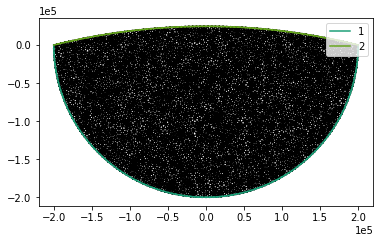

In [8]:
fig, axes = icepack.plot.subplots()
icepack.plot.triplot(mesh)
plt.show(fig)

In the demos for real glaciers that follow, we use all of the same tools.
The main difference is that the boundary arcs are drawn by hand in a geographic information system, rather than defined programatically in Python.
In the repository [glacier-meshes](https://github.com/icepack/glacier-meshes) I've included shapefiles of the outlines of several glaciers and a program to automate the translation of a shapefile into a .geo file using pygmsh.
This will be used in the demo for the Larsen Ice Shelf.

### Input data

To mimic the state of a real ice shelf, we'll pick a few angles along the inflow boundary that represent the centerlines of the ice streams that feed the shelf.
We'll then define velocity and thickness profiles along this inflow boundary.
We don't have a great idea from the outset of what the steady state of the ice shelf is; it doesn't have a simple analytical expression in terms of the coordinates.
Instead, we'll pick a somewhat arbitrary initial profile and evolve it towards steady state.

Many ice shelves (Larsen, Ross, etc.) have several streams feeding them.
Our synthetic glacier will be fed by four streams.
We'll define the inlets by picking the angles around the inflow boundary where each inlet comes in from and the width in radians.
You can re-run this notebook and change the values or the number of streams to whatever you like.

In [9]:
inlet_angles = π * np.array([-3/4, -1/2, -1/3, -1/6])
inlet_widths = π * np.array([1/8, 1/12, 1/24, 1/12])

Next, we'll come up with some rather arbitrary and un-physical input data.
The basic idea is to make the thickness slope down as you go towards the calving terminus and away from the centerline of an inlet.
Likewise the ice speed goes up as you go towards the calving terminus.
In order to make this big nasty algebraic expression, we'll create a list of the perturbation thickness and velocity for each inlet, and combine them all together at the end.

In [10]:
x = firedrake.SpatialCoordinate(mesh)

u_in = 300
h_in = 350
hb = 100
dh, du = 400, 250

hs, us = [], []
for θ, ϕ in zip(inlet_angles, inlet_widths):
    x0 = R * as_vector((np.cos(θ), np.sin(θ)))
    v = -as_vector((np.cos(θ), np.sin(θ)))
    L = inner(x - x0, v)
    W = x - x0 - L * v
    Rn = 2 * ϕ / π * R
    q = firedrake.max_value(1 - (W / Rn)**2, 0)
    hs.append(hb + q * ((h_in - hb) - dh * L /R))
    us.append(firedrake.exp(-4 * (W/R)**2) * (u_in + du * L / R) * v)

To combine the expressions for the thickness and velocity of each inlet into expressions for the whole ice shelf, we'll take the maximum thickness at any point, and the sum of the velocities.

In [11]:
h_expr = firedrake.Constant(hb)
for h in hs:
    h_expr = firedrake.max_value(h, h_expr)
    
u_expr = sum(us)

These are merely algebraic expressions.
To start modeling we need to interpolate these expressions to some function spaces defined over the mesh.

In [12]:
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2)
V = firedrake.VectorFunctionSpace(mesh, family='CG', degree=2)

h0 = firedrake.interpolate(h_expr, Q)
u0 = firedrake.interpolate(u_expr, V)

The algebra might be a little opaque, but the plots of the initial data should be more illuminating.

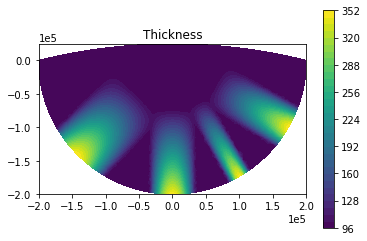

In [13]:
fig, axes = icepack.plot.subplots()
axes.set_title('Thickness')
contours = icepack.plot.tricontourf(h0, 40, axes=axes)
fig.colorbar(contours)

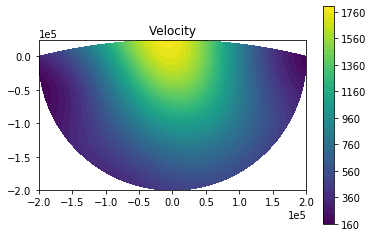

In [14]:
fig, axes = icepack.plot.subplots()
axes.set_title('Velocity')
contours = icepack.plot.tricontourf(u0, 40, axes=axes)
fig.colorbar(contours)

As the simulation progresses, the ice streams, as represented by areas with higher thickness, will spread and grow.

### Modeling

To actually start solving things, we'll make an `IceShelf` object that represents the physical model we're using.
Each model type has two methods, `diagnostic_solve` and `prognostic_solve`, that solve the PDEs for the ice velocity and thickness.

In [15]:
ice_shelf = icepack.models.IceShelf()
help(ice_shelf.diagnostic_solve)

Help on method diagnostic_solve in module icepack.models.ice_shelf:

diagnostic_solve(u0, h, dirichlet_ids, tol=1e-06, **kwargs) method of icepack.models.ice_shelf.IceShelf instance
    Solve for the ice velocity from the thickness
    
    Parameters
    ----------
    u0 : firedrake.Function
        Initial guess for the ice velocity; the Dirichlet boundaries
        are taken from `u0`
    h : firedrake.Function
        Ice thickness
    dirichlet_ids : list of int
        list of integer IDs denoting the parts of the boundary where
        Dirichlet conditions should be applied
    tol : float
        dimensionless tolerance for when to terminate Newton's method
    
    Returns
    -------
    u : firedrake.Function
        Ice velocity
    
    Other parameters
    ----------------
    **kwargs
        All other keyword arguments will be passed on to the
        `viscosity` and `gravity` functions that were set when this
        model object was initialized



For now we'll use a fluidity that assumes a spatially constant temperature of -18${}^\circ$C.
The code itself assumes that all temperatures are in Kelvin.
In later demos, we'll use a spatially variable fluidity coefficient and show how to infer it from observations.

In [16]:
T = firedrake.Constant(255.15)
A = firedrake.interpolate(icepack.rate_factor(T), Q)

Finally, we need to prescribe the boundary conditions for the velocity and the convergence tolerance for the nonlinear solver.
Since the boundary conditions and convergence tolerance are usually the same throughout a simulation, we'll pack them into a dictionary call `opts` and reuse it throughout.

To compute the velocity field, we call the diagnostic solve method of the ice shelf object.
This function takes in the initial guess `u0` for the velocity, the thickness, the fluidity, and all the extra options we packed into `opts`.

In [17]:
opts = {'dirichlet_ids': [1], 'tol': 1e-12}
h = h0.copy(deepcopy=True)
u = ice_shelf.diagnostic_solve(u0=u0, h=h, A=A, **opts)

Here we passed all the arguments to `diagnostic_solve` as keywords.
This convention will be used throughout all the demos.
Passing arguments by keyword is slightly more verbose than passing them by position, but it saves you the trouble of remembering what order everything goes in.
On top of that, many fields are *only* passed in as keyword arguments.
For example, the fluidity parameter is not a positional argument of the diagnostic solve routine.
The reason for this choice, as we'll see later, is that it's much easier to swap out components of the model physics for your own customized versions.

The following plot shows streamlines of the velocity field.
These kind of plots are useful for showing areas of convergence and divergence of the flow field.

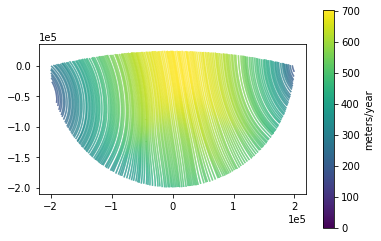

In [18]:
fig, axes = icepack.plot.subplots()
streamlines = icepack.plot.streamplot(u, precision=1e3, density=2e3, axes=axes)
fig.colorbar(streamlines, label='meters/year')
plt.show(fig)

To project the state of the ice shelf forward in time, we'll use the prognostic solve method.
The prognostic solver updates the ice thickness forward by a given timestep given the accumulation rate and velocity.
We then update the velocity using the diagnostic solver at each timestep.
The following code runs the model forward for several years until the ice shelf is roughly in steady state.

In [19]:
T = 250.0
num_timesteps = 125
dt = T / num_timesteps
a = firedrake.Constant(0.0)

for step in range(num_timesteps + 1):
    h = ice_shelf.prognostic_solve(dt, h0=h, a=a, u=u, h_inflow=h0)
    u = ice_shelf.diagnostic_solve(u0=u, h=h, A=A, **opts)
    
    print('.' if step % 10 == 0 else '', end='', flush=True)

.............

The main loop to run the simulation consists of alternating calls to the prognostic and diagnostic solve methods of the model object.
We'll see this pattern repeated in all of the demos that follow.
In some cases we'll add in extra physics, like updating the temperature or damage field, but the core idea is the same.

We've added a bit of feedback to the loop by printing out a period every 10 iterations.
These kinds of diagnostics are helpful to know that the simulation is actually running and that it hasn't frozen.
But you can also put in whatever extra code you want here.
For example, you might want to make plots of the thickness and velocity, print out some physical quantity like the total flux of ice out of the calving front, or accumulate the fields into a list so that you can analyze the entire time series later.

To wrap things up, we'll make a plot of the final ice thickness and velocity.
The initial thickness profile of each ice stream, which flattened out in the middle of the shelf, has extended all the way to the terminus.

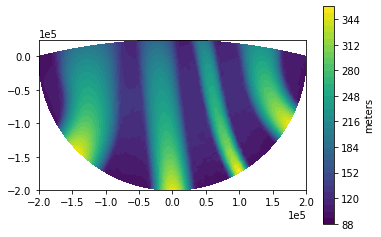

In [20]:
fig, axes = icepack.plot.subplots()
contours = icepack.plot.tricontourf(h, 40, axes=axes)
fig.colorbar(contours, label='meters')
plt.show(fig)

A stream plot of the ice velocity shows that the areas of greatest flow divergence have moved around relative to the initial velocity.

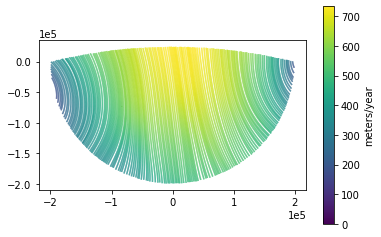

In [21]:
fig, axes = icepack.plot.subplots()
streamlines = icepack.plot.streamplot(u, precision=1e3, density=2e3, axes=axes)
fig.colorbar(streamlines, label='meters/year')
plt.show(fig)

A useful quantity to know is how much ice is moving through the system.
In the previous demo, we showed how to symbolically create functionals of the solution.
We can use this to calculate the total ice flux through the calving terminus.

In [22]:
ν = firedrake.FacetNormal(mesh)
flux = h * inner(u, ν) * ds(2)

The extra argument to `ds` indicates that we want to integrate over just the calving terminus rather than over the entire domain boundary.
The variable `flux` is a symbolic representation of this quantity in terms of the input fields; it isn't a number but rather a description of how to compute a number.
The function `firedrake.assemble` does the actual work of evaluating the integral.

In [23]:
print('Flux: {} km^3 / year'.format(firedrake.assemble(flux) / 1e9))

Flux: 36.03967135609979 km^3 / year


To check the degree to which the system really is in steady state, we can compute the flux along the inflow boundary rather than along the terminus.
This should be equal to the flux out of the domain since we've set the accumulation rate to be zero.

In [24]:
influx = -h * inner(u, ν) * ds(1)
print('Influx: {} km^3 / year'.format(firedrake.assemble(influx) / 1e9))

Influx: 38.15826841517492 km^3 / year


The influx and outflux are reasonably close, with the influx slightly exceeding the outflux.
The ice shelf will thicken, increasing the flux out of the terminus, until the two values equilibrate.
If you want to experiment with this example a bit more, you can increase the final time $T$ and then compare the fluxes.

### Conclusion

In the last demo, we saw how to create a mesh, define a finite element space, interpolate functions to that finite element space, and analyze the results through either plotting or more general post-processing.
Here we've shown how to use these functions as an input to an ice shelf flow model.
There are a lot of interesting experiments you can do with synthetic ice shelves.
For example, you can approximate the effect of seasonality by making the accumulation rate and inflow thickness a sinusoidal function of time.
You can then add things like tidal effects and see how they alter the overall ice flow.
In the next demo, we'll show how to use these functions for simulating a real ice shelf using observational data.